In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [43]:
all_targets = np.vstack([train_targets, valid_targets, test_targets])


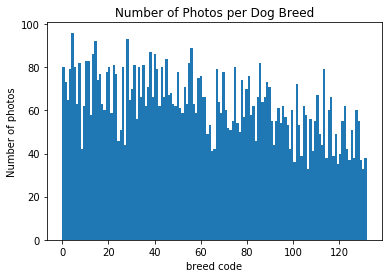

In [100]:
x =  np.argmax(all_targets,axis=1)
plt.title("Number of Photos per Dog Breed")
plt.xlabel("breed code")
plt.ylabel("Number of photos")
plt.hist(x, bins=133);
plt.savefig('plots/histogram.png')

In [102]:
%matplotlib inline
num_per_class = []
total = 0
for i in range(133):
    per_class_i = len(np.where(np.argmax(all_targets, axis = 1) == i)[0])
    num_per_class.append(per_class_i)
    total+=per_class_i
    
num_per_class_array = np.array(num_per_class)

# print num_per_class_array

hist, bin_edges=np.histogram(num_per_class_array, bins='auto')
# print hist

min_i = np.argmin(num_per_class)
max_i = np.argmax(num_per_class)
print dog_names[min_i],num_per_class[min_i]
print dog_names[max_i],num_per_class[max_i]

Norwegian_buhund 33
Alaskan_malamute 96


In [2]:
train_tensors = np.load('train_tensors.npy')
valid_tensors = np.load('valid_tensors.npy')
test_tensors = np.load('test_tensors.npy')

In [ ]:
# Train a small network from scratch

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    shear_range = 0.2, # rnadomly applying shear transformation
    zoom_range = 0.2, # randomly zooming inside pictures
    fill_mode = 'nearest')
# fit augmented image generator on data
datagen.fit(train_tensors)

In [4]:
print(train_tensors.shape)

(6680, 224, 224, 3)


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

# # Use with data augmentation example
# model.add(Dense(266, activation='relu'))
# model.add(Dropout(0.5))
# # END: Use with data augmentation example


model.add(Dense(133, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 54, 54, 32)        128       
__________

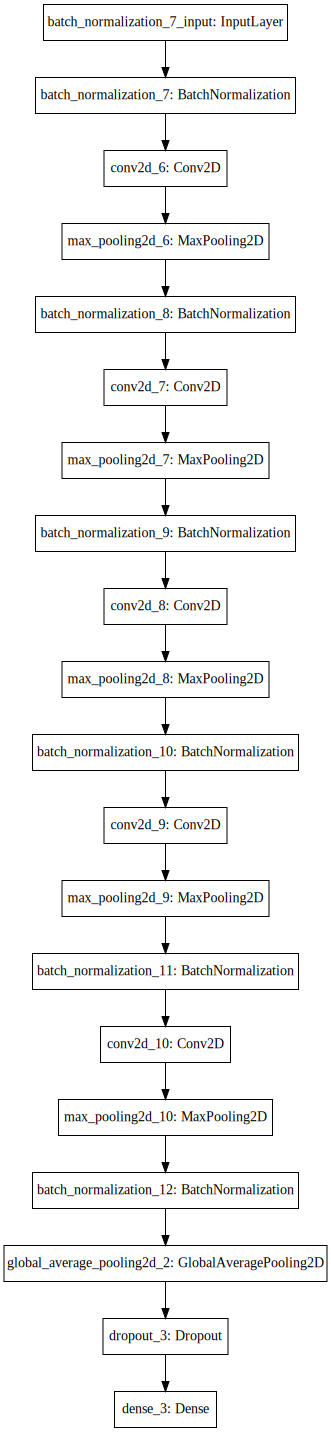

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='plots/scratch.png')

In [12]:
# NO DATA AUGMENTATION

from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping

epochs = 30
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
history_scratch = model.fit(train_tensors, train_targets, batch_size=batch_size,
                    validation_data=(valid_tensors, valid_targets), 
                    epochs=epochs, callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 49s 7ms/step - loss: 4.7934 - acc: 0.0305 - val_loss: 4.8214 - val_acc: 0.0263
Epoch 2/30
6680/6680 [==============================] - 47s 7ms/step - loss: 4.3414 - acc: 0.0665 - val_loss: 4.1237 - val_acc: 0.0838
Epoch 3/30
6680/6680 [==============================] - 47s 7ms/step - loss: 4.0568 - acc: 0.0897 - val_loss: 4.0376 - val_acc: 0.1126
Epoch 4/30
6680/6680 [==============================] - 47s 7ms/step - loss: 3.8023 - acc: 0.1225 - val_loss: 3.9058 - val_acc: 0.1066
Epoch 5/30
6680/6680 [==============================] - 47s 7ms/step - loss: 3.5404 - acc: 0.1630 - val_loss: 3.5900 - val_acc: 0.1413
Epoch 6/30
6680/6680 [==============================] - 47s 7ms/step - loss: 3.3311 - acc: 0.1948 - val_loss: 3.4305 - val_acc: 0.1916
Epoch 7/30
6680/6680 [==============================] - 47s 7ms/step - loss: 3.0760 - acc: 0.2415 - val_loss: 3.2977 - val_acc: 0.1952
Epoch 8/

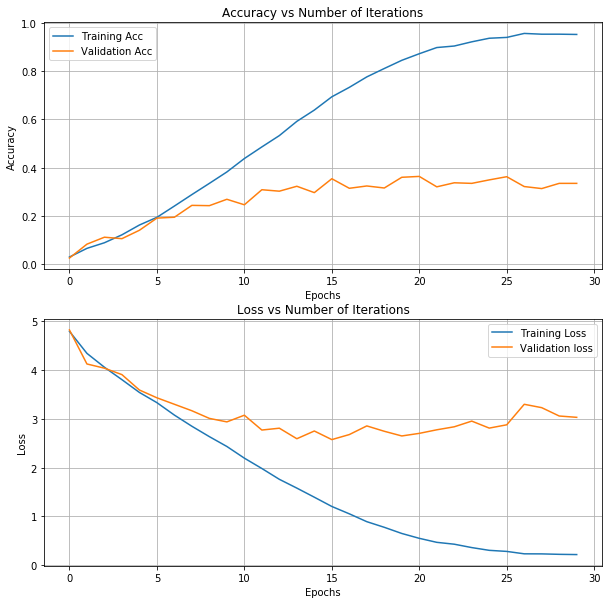

In [17]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_scratch.history['acc'], label = "Training Acc")
plt.plot(history_scratch.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_scratch.history['loss'], label = "Training Loss")
plt.plot(history_scratch.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_scratch.png')
plt.show()



In [18]:
model.load_weights('saved_models/weights.from_scratch.hdf5')

In [19]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 35.8852%


In [20]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(dog_breed_predictions)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 35.4491%


In [ ]:
pic_i = 16
print(np.argmax(model.predict(test_tensors[pic_i:pic_i+1])))
print(model.predict(test_tensors[pic_i:pic_i+1]).argsort())
print(np.argmax(test_targets[pic_i]))

In [ ]:
# DATA AUGMENTATION

In [24]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.normalization import BatchNormalization

model_aug = Sequential()
model_aug.add(BatchNormalization(input_shape=(224, 224, 3)))
model_aug.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(BatchNormalization())

model_aug.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(BatchNormalization())

model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dropout(0.5))

# # Use with data augmentation example
# model_aug.add(Dense(266, activation='relu'))
# model_aug.add(Dropout(0.5))
# # END: Use with data augmentation example


model_aug.add(Dense(133, activation='softmax'))

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 54, 54, 32)        128       
__________

In [25]:
from keras.utils import plot_model
plot_model(model_aug, to_file='plots/scratch_aug.png')

In [26]:
# WITH DATA AUGMENTATION (need to recompile the model before running)

from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping

epochs = 30
batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/scratch_aug.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
history_scratch_aug = model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)], verbose=1)

Epoch 1/30
209/208 [==============================] - 62s 297ms/step - loss: 2.6054 - acc: 0.3263 - val_loss: 2.7795 - val_acc: 0.3389
Epoch 2/30
209/208 [==============================] - 60s 288ms/step - loss: 2.3910 - acc: 0.3708 - val_loss: 2.7438 - val_acc: 0.3174
Epoch 3/30
209/208 [==============================] - 60s 286ms/step - loss: 2.2923 - acc: 0.3961 - val_loss: 2.4111 - val_acc: 0.3856
Epoch 4/30
209/208 [==============================] - 60s 288ms/step - loss: 2.1780 - acc: 0.4110 - val_loss: 2.4894 - val_acc: 0.3665
Epoch 5/30
209/208 [==============================] - 60s 289ms/step - loss: 2.0753 - acc: 0.4367 - val_loss: 2.2746 - val_acc: 0.4048
Epoch 6/30
209/208 [==============================] - 60s 287ms/step - loss: 2.0637 - acc: 0.4457 - val_loss: 2.2639 - val_acc: 0.4180
Epoch 7/30
209/208 [==============================] - 61s 290ms/step - loss: 1.9841 - acc: 0.4630 - val_loss: 2.1769 - val_acc: 0.4240
Epoch 8/30
209/208 [==============================] - 6

Epoch 30/30
209/208 [==============================] - 60s 285ms/step - loss: 1.2753 - acc: 0.6357 - val_loss: 1.6447 - val_acc: 0.5677


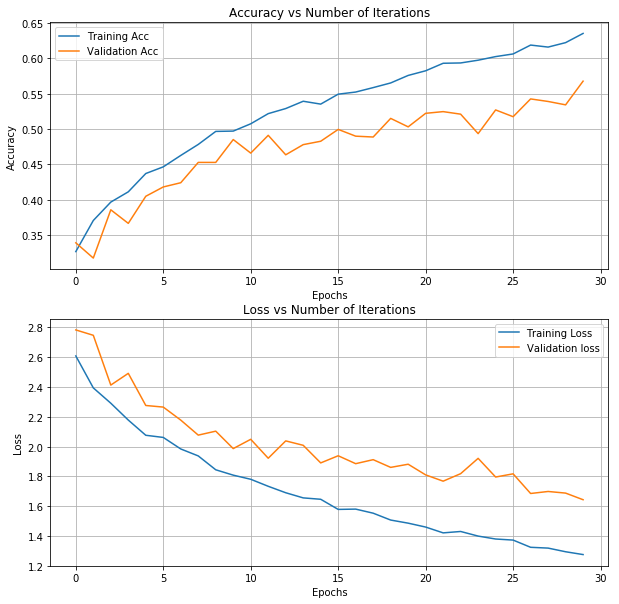

In [30]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_scratch_aug.history['acc'], label = "Training Acc")
plt.plot(history_scratch_aug.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_scratch_aug.history['loss'], label = "Training Loss")
plt.plot(history_scratch_aug.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_scratch_aug.png')
plt.show()

In [31]:
model.load_weights('saved_models/scratch_aug.hdf5')

In [32]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.4258%


In [33]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in valid_tensors]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(dog_breed_predictions)==np.argmax(valid_targets, axis=1))/len(dog_breed_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 56.7665%


In [ ]:
#RESNET-50

In [3]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet_features = bottleneck_features['train']
valid_resnet_features = bottleneck_features['valid']
test_resnet_features = bottleneck_features['test']

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_resnet_features.shape[1:]))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dropout(0.5))

ResNet_model.add(Dense(2 * 133,activation='relu'))
ResNet_model.add(BatchNormalization())
ResNet_model.add(Dropout(0.5))

ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_20 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               35511     
Total para

In [36]:
from keras.utils import plot_model
plot_model(ResNet_model, to_file='plots/resnet.png')

In [37]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/resnet_transfer.hdf5', 
                               verbose=1, save_best_only=True)


history_resnet = ResNet_model.fit(train_resnet_features, train_targets, 
          batch_size = 128,
          epochs=30,
          verbose=1,
          validation_data=(valid_resnet_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 1s 206us/step - loss: 3.8759 - acc: 0.2019 - val_loss: 2.0933 - val_acc: 0.5796
Epoch 2/30
6680/6680 [==============================] - 0s 69us/step - loss: 1.7492 - acc: 0.5609 - val_loss: 1.3134 - val_acc: 0.7210
Epoch 3/30
6680/6680 [==============================] - 0s 67us/step - loss: 1.1717 - acc: 0.6922 - val_loss: 0.9811 - val_acc: 0.7617
Epoch 4/30
6680/6680 [==============================] - 0s 68us/step - loss: 0.9298 - acc: 0.7522 - val_loss: 0.8087 - val_acc: 0.7916
Epoch 5/30
6680/6680 [==============================] - 0s 67us/step - loss: 0.7571 - acc: 0.7934 - val_loss: 0.7211 - val_acc: 0.7880
Epoch 6/30
6680/6680 [==============================] - 0s 68us/step - loss: 0.6426 - acc: 0.8175 - val_loss: 0.6553 - val_acc: 0.8156
Epoch 7/30
6680/6680 [==============================] - 0s 68us/step - loss: 0.5592 - acc: 0.8386 - val_loss: 0.6211 - val_acc: 0.8204
Epoch 8

Epoch 28/30
6680/6680 [==============================] - 0s 58us/step - loss: 0.1496 - acc: 0.9542 - val_loss: 0.5261 - val_acc: 0.8323
Epoch 29/30
6680/6680 [==============================] - 0s 62us/step - loss: 0.1514 - acc: 0.9557 - val_loss: 0.4970 - val_acc: 0.8371
Epoch 30/30
6680/6680 [==============================] - 0s 58us/step - loss: 0.1443 - acc: 0.9548 - val_loss: 0.5099 - val_acc: 0.8383


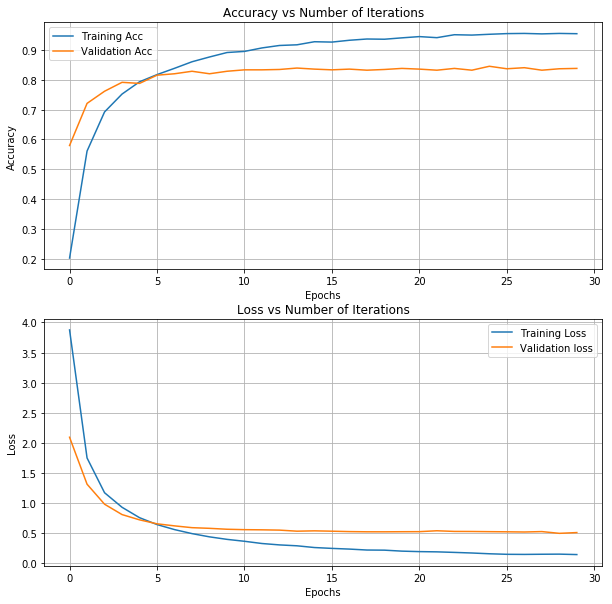

In [38]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_resnet.history['acc'], label = "Training Acc")
plt.plot(history_resnet.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_resnet.history['loss'], label = "Training Loss")
plt.plot(history_resnet.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_resnet.png')
plt.show()

In [39]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/resnet_transfer.hdf5')

In [40]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.6555%


In [41]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_resnet_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(ResNet50_predictions)==np.argmax(valid_targets, axis=1))/len(ResNet50_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 83.7126%


In [ ]:
# INCEPTION

In [4]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception_features = bottleneck_features['train']
valid_inception_features = bottleneck_features['valid']
test_inception_features = bottleneck_features['test']

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception_features.shape[1:]))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.5))

inception_model.add(Dense(2 * 133,activation='relu'))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(0.5))

inception_model.add(Dense(133, activation='softmax'))

inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_2 (Batch (None, 266)               1064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 266)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               35511     
Total para

In [44]:
from keras.utils import plot_model
plot_model(inception_model, to_file='plots/inception.png')

In [7]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/inception_transfer.hdf5', 
                               verbose=1, save_best_only=True)


history_inception = inception_model.fit(train_inception_features, train_targets, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_inception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 12s 2ms/step - loss: 1.9362 - acc: 0.5389 - val_loss: 0.6054 - val_acc: 0.8024
Epoch 2/30
6680/6680 [==============================] - 6s 937us/step - loss: 0.9318 - acc: 0.7311 - val_loss: 0.5392 - val_acc: 0.8240
Epoch 3/30
6680/6680 [==============================] - 6s 944us/step - loss: 0.7976 - acc: 0.7626 - val_loss: 0.5368 - val_acc: 0.8395
Epoch 4/30
6680/6680 [==============================] - 6s 945us/step - loss: 0.7090 - acc: 0.7840 - val_loss: 0.5484 - val_acc: 0.8395
Epoch 5/30
6680/6680 [==============================] - 6s 947us/step - loss: 0.6649 - acc: 0.7978 - val_loss: 0.5413 - val_acc: 0.8383
Epoch 6/30
6680/6680 [==============================] - 6s 952us/step - loss: 0.5974 - acc: 0.8178 - val_loss: 0.5311 - val_acc: 0.8395
Epoch 7/30
6680/6680 [==============================] - 6s 953us/step - loss: 0.5683 - acc: 0.8265 - val_loss: 0.5651 - val_acc: 0.8491
Ep

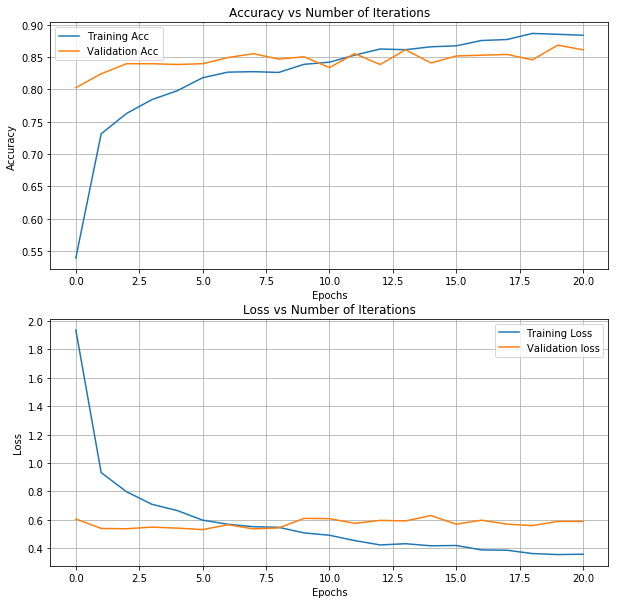

In [8]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_inception.history['acc'], label = "Training Acc")
plt.plot(history_inception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_inception.history['loss'], label = "Training Loss")
plt.plot(history_inception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_inception.png')
plt.show()


In [47]:
### Load the model weights with the best validation loss.
inception_model.load_weights('saved_models/inception_transfer.hdf5')

In [49]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.1340%


In [50]:
# get index of predicted dog breed for each image in test set
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_inception_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(inception_predictions)==np.argmax(valid_targets, axis=1))/len(inception_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 85.1497%


In [ ]:
#XCEPTION

In [51]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_xception_features = bottleneck_features['train']
valid_xception_features = bottleneck_features['valid']
test_xception_features = bottleneck_features['test']

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

xception_model = Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=train_xception_features.shape[1:]))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))

xception_model.add(Dense(2 * 133,activation='relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dropout(0.5))

xception_model.add(Dense(133, activation='softmax'))

xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 266)               545034    
_________________________________________________________________
batch_normalization_24 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_10 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               35511     
Total para

In [53]:
from keras.utils import plot_model
plot_model(xception_model, to_file='plots/xception.png')

In [54]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/xception_transfer.hdf5', 
                               verbose=1, save_best_only=True)


history_xception = xception_model.fit(train_xception_features, train_targets, 
          batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=(valid_xception_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 9s 1ms/step - loss: 1.9511 - acc: 0.5362 - val_loss: 0.6657 - val_acc: 0.8048
Epoch 2/30
6680/6680 [==============================] - 8s 1ms/step - loss: 0.9479 - acc: 0.7292 - val_loss: 0.6144 - val_acc: 0.8251
Epoch 3/30
6680/6680 [==============================] - 7s 1ms/step - loss: 0.8374 - acc: 0.7522 - val_loss: 0.5573 - val_acc: 0.8120
Epoch 4/30
6680/6680 [==============================] - 7s 1ms/step - loss: 0.7305 - acc: 0.7867 - val_loss: 0.5418 - val_acc: 0.8275
Epoch 5/30
6680/6680 [==============================] - 7s 1ms/step - loss: 0.6862 - acc: 0.7948 - val_loss: 0.5364 - val_acc: 0.8443
Epoch 6/30
6680/6680 [==============================] - 7s 1ms/step - loss: 0.6487 - acc: 0.8063 - val_loss: 0.5242 - val_acc: 0.8419
Epoch 7/30
6680/6680 [==============================] - 7s 1ms/step - loss: 0.6110 - acc: 0.8088 - val_loss: 0.5856 - val_acc: 0.8359
Epoch 8/30
6680

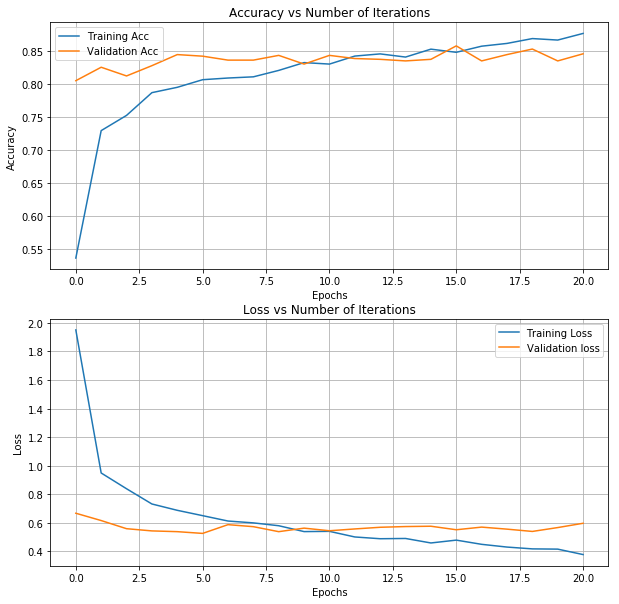

In [55]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_xception.history['acc'], label = "Training Acc")
plt.plot(history_xception.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_xception.history['loss'], label = "Training Loss")
plt.plot(history_xception.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_xception.png')
plt.show()


In [56]:
### Load the model weights with the best validation loss.
xception_model.load_weights('saved_models/xception_transfer.hdf5')

In [58]:
# get index of predicted dog breed for each image in test set
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.2105%


In [59]:
# get index of predicted dog breed for each image in test set
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_xception_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(xception_predictions)==np.argmax(valid_targets, axis=1))/len(xception_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 84.1916%


In [ ]:
# VGG19

In [60]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_vgg19_features = bottleneck_features['train']
valid_vgg19_features = bottleneck_features['valid']
test_vgg19_features = bottleneck_features['test']

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

vgg19_model = Sequential()
vgg19_model.add(GlobalAveragePooling2D(input_shape=train_vgg19_features.shape[1:]))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(2 * 133,activation='relu'))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dropout(0.5))

vgg19_model.add(Dense(133, activation='softmax'))

vgg19_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 266)               136458    
_________________________________________________________________
batch_normalization_28 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_14 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 133)               35511     
Total para

In [66]:
from keras.utils import plot_model
plot_model(vgg19_model, to_file='plots/vgg19.png')

In [67]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/vgg19_transfer.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg19 = vgg19_model.fit(train_vgg19_features, train_targets, 
          batch_size = 32,
          epochs=50,
          verbose=1,
          validation_data=(valid_vgg19_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 3s 465us/step - loss: 4.2949 - acc: 0.1301 - val_loss: 2.1050 - val_acc: 0.5186
Epoch 2/50
6680/6680 [==============================] - 2s 261us/step - loss: 2.3721 - acc: 0.3997 - val_loss: 1.3814 - val_acc: 0.6599
Epoch 3/50
6680/6680 [==============================] - 2s 265us/step - loss: 1.7592 - acc: 0.5169 - val_loss: 1.0780 - val_acc: 0.7497
Epoch 4/50
6680/6680 [==============================] - 2s 261us/step - loss: 1.4400 - acc: 0.5907 - val_loss: 0.9523 - val_acc: 0.7401
Epoch 5/50
6680/6680 [==============================] - 2s 264us/step - loss: 1.2784 - acc: 0.6289 - val_loss: 0.8563 - val_acc: 0.7641
Epoch 6/50
6680/6680 [==============================] - 2s 268us/step - loss: 1.1681 - acc: 0.6566 - val_loss: 0.8012 - val_acc: 0.7689
Epoch 7/50
6680/6680 [==============================] - 2s 254us/step - loss: 1.0464 - acc: 0.6793 - val_loss: 0.7555 - val_acc: 0.7689
E

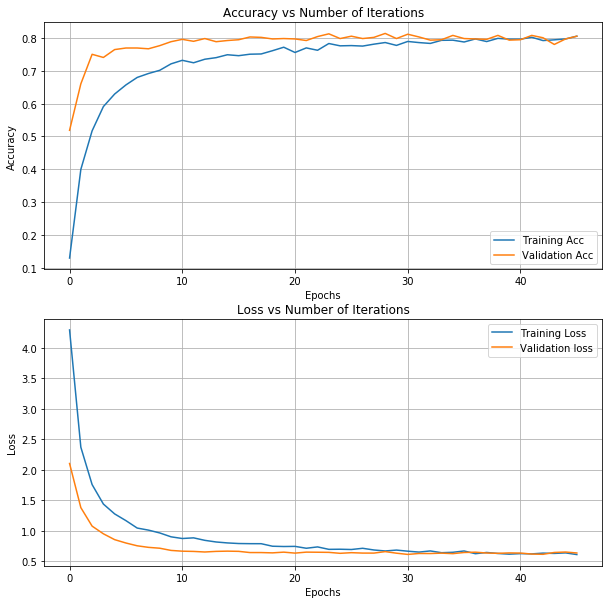

In [68]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_vgg19.history['acc'], label = "Training Acc")
plt.plot(history_vgg19.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_vgg19.history['loss'], label = "Training Loss")
plt.plot(history_vgg19.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_vgg19.png')
plt.show()

In [69]:
### Load the model weights with the best validation loss.
vgg19_model.load_weights('saved_models/vgg19_transfer.hdf5')

In [70]:
# get index of predicted dog breed for each image in test set
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg19_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg19_predictions)==np.argmax(test_targets, axis=1))/len(vgg19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.4258%


In [71]:
# get index of predicted dog breed for each image in test set
vgg19_predictions = [np.argmax(vgg19_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_vgg19_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(vgg19_predictions)==np.argmax(valid_targets, axis=1))/len(vgg19_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 81.0778%


In [ ]:
#VGG16

In [72]:
# Alternatively just use saved pretrained features
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_vgg16_features = bottleneck_features['train']
valid_vgg16_features = bottleneck_features['valid']
test_vgg16_features = bottleneck_features['test']

In [76]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

vgg16_model = Sequential()
vgg16_model.add(GlobalAveragePooling2D(input_shape=train_vgg16_features.shape[1:]))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(2 * 133,activation='relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dropout(0.5))

vgg16_model.add(Dense(133, activation='softmax'))

vgg16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 266)               136458    
_________________________________________________________________
batch_normalization_32 (Batc (None, 266)               1064      
_________________________________________________________________
dropout_18 (Dropout)         (None, 266)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               35511     
Total para

In [77]:
from keras.utils import plot_model
plot_model(vgg16_model, to_file='plots/vgg16.png')

In [78]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/vgg16_transfer.hdf5', 
                               verbose=1, save_best_only=True)


history_vgg16 = vgg16_model.fit(train_vgg16_features, train_targets, 
          batch_size = 32,
          epochs=50,
          verbose=1,
          validation_data=(valid_vgg16_features, valid_targets),
          callbacks=[checkpointer, EarlyStopping(min_delta=1e-7, patience=15)
          ])

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 3s 506us/step - loss: 4.3589 - acc: 0.1162 - val_loss: 2.2185 - val_acc: 0.4838
Epoch 2/50
6680/6680 [==============================] - 2s 265us/step - loss: 2.4500 - acc: 0.3714 - val_loss: 1.4638 - val_acc: 0.6407
Epoch 3/50
6680/6680 [==============================] - 2s 266us/step - loss: 1.8252 - acc: 0.4997 - val_loss: 1.1272 - val_acc: 0.7174
Epoch 4/50
6680/6680 [==============================] - 2s 254us/step - loss: 1.4951 - acc: 0.5804 - val_loss: 0.9651 - val_acc: 0.7509
Epoch 5/50
6680/6680 [==============================] - 2s 250us/step - loss: 1.3175 - acc: 0.6163 - val_loss: 0.8681 - val_acc: 0.7617
Epoch 6/50
6680/6680 [==============================] - 2s 259us/step - loss: 1.2032 - acc: 0.6436 - val_loss: 0.8174 - val_acc: 0.7725
Epoch 7/50
6680/6680 [==============================] - 2s 246us/step - loss: 1.1208 - acc: 0.6686 - val_loss: 0.7738 - val_acc: 0.7665
E

Epoch 28/50
6680/6680 [==============================] - 2s 238us/step - loss: 0.7494 - acc: 0.7654 - val_loss: 0.6525 - val_acc: 0.7952
Epoch 29/50
6680/6680 [==============================] - 2s 238us/step - loss: 0.6955 - acc: 0.7835 - val_loss: 0.6495 - val_acc: 0.7856
Epoch 30/50
6680/6680 [==============================] - 2s 237us/step - loss: 0.7163 - acc: 0.7596 - val_loss: 0.6578 - val_acc: 0.7820
Epoch 31/50
6680/6680 [==============================] - 2s 238us/step - loss: 0.6968 - acc: 0.7740 - val_loss: 0.6567 - val_acc: 0.8072
Epoch 32/50
6680/6680 [==============================] - 2s 237us/step - loss: 0.7172 - acc: 0.7692 - val_loss: 0.6336 - val_acc: 0.7988
Epoch 33/50
6680/6680 [==============================] - 2s 239us/step - loss: 0.6868 - acc: 0.7838 - val_loss: 0.6491 - val_acc: 0.7928
Epoch 34/50
6680/6680 [==============================] - 2s 251us/step - loss: 0.6536 - acc: 0.7891 - val_loss: 0.6287 - val_acc: 0.8036
Epoch 35/50
6680/6680 [==================

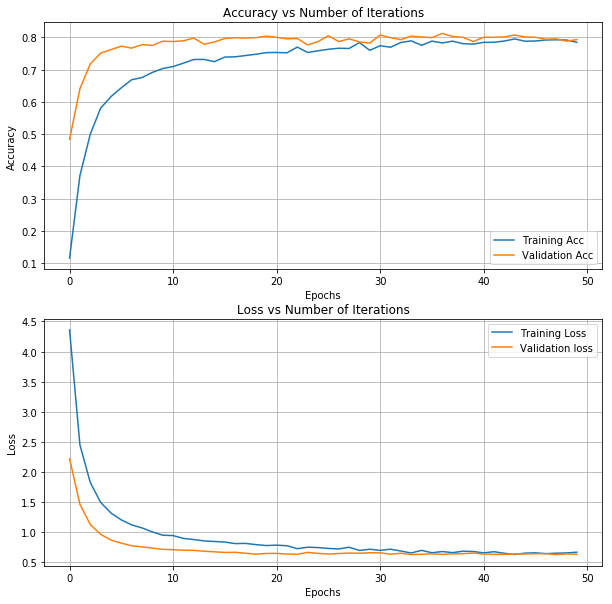

In [79]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10,10))
plt.subplot(2, 1, 1)

plt.plot(history_vgg16.history['acc'], label = "Training Acc")
plt.plot(history_vgg16.history['val_acc'], label = "Validation Acc")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Iterations")
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(history_vgg16.history['loss'], label = "Training Loss")
plt.plot(history_vgg16.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of Iterations")
plt.grid()
plt.savefig('plots/training_vgg16.png')
plt.show()

In [80]:
### Load the model weights with the best validation loss.
vgg16_model.load_weights('saved_models/vgg16_transfer.hdf5')

In [82]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg16_features]

# report test accuracy
test_accuracy = 100.0*np.sum(np.array(vgg16_predictions)==np.argmax(test_targets, axis=1))/len(vgg16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.2632%


In [83]:
# get index of predicted dog breed for each image in test set
vgg16_predictions = [np.argmax(vgg16_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_vgg16_features]

# report test accuracy
valid_accuracy = 100.0*np.sum(np.array(vgg16_predictions)==np.argmax(valid_targets, axis=1))/len(vgg16_predictions)
print('Validation accuracy: %.4f%%' % valid_accuracy)

Validation accuracy: 79.5210%


In [ ]:
# ENSEMBLE: Validation accuracy

In [98]:
# Calculate prediction vectors
vgg16_predict_valid = vgg16_model.predict(valid_vgg16_features)
vgg19_predict_valid = vgg19_model.predict(valid_vgg19_features)
resnet_predict_valid = ResNet_model.predict(valid_resnet_features)
inception_predict_valid = inception_model.predict(valid_inception_features)
xception_predict_valid = xception_model.predict(valid_xception_features)

In [99]:
# Calculating "weights"
vgg16_valid_accuracy = 1.0*np.sum(np.argmax(vgg16_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
vgg19_valid_accuracy = 1.0*np.sum(np.argmax(vgg19_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
resnet_valid_accuracy = 1.0*np.sum(np.argmax(resnet_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
inception_valid_accuracy = 1.0*np.sum(np.argmax(inception_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)
xception_valid_accuracy = 1.0*np.sum(np.argmax(xception_predict_valid, axis = 1)==np.argmax(valid_targets, axis=1))/len(valid_targets)

In [100]:
ensemble_weights =  np.add(vgg16_valid_accuracy*vgg16_predict_valid, vgg19_valid_accuracy*vgg19_predict_valid)
ensemble_weights = np.add(ensemble_weights, resnet_valid_accuracy*resnet_predict_valid)
ensemble_weights = np.add(ensemble_weights, inception_valid_accuracy*inception_predict_valid)
ensemble_weights = np.add(ensemble_weights, xception_valid_accuracy*xception_predict_valid)
print ensemble_weights.shape

(835, 133)


In [101]:
ensemble_predictions = np.argmax(ensemble_weights, axis = 1)

In [102]:
ensemble_valid_accuracy = 100.0*np.sum(ensemble_predictions==np.argmax(valid_targets, axis=1))/len(ensemble_predictions)
print('Validation accuracy: %.4f%%' % ensemble_valid_accuracy)

Validation accuracy: 89.5808%


In [103]:
# ENSEMBLE: test accuracy

In [104]:
# Calculate prediction vectors
vgg16_predict_test = vgg16_model.predict(test_vgg16_features)
vgg19_predict_test = vgg19_model.predict(test_vgg19_features)
resnet_predict_test = ResNet_model.predict(test_resnet_features)
inception_predict_test = inception_model.predict(test_inception_features)
xception_predict_test = xception_model.predict(test_xception_features)

In [105]:
# Calculating "weights"
vgg16_test_accuracy = 1.0*np.sum(np.argmax(vgg16_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
vgg19_test_accuracy = 1.0*np.sum(np.argmax(vgg19_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
resnet_test_accuracy = 1.0*np.sum(np.argmax(resnet_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
inception_test_accuracy = 1.0*np.sum(np.argmax(inception_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)
xception_test_accuracy = 1.0*np.sum(np.argmax(xception_predict_test, axis = 1)==np.argmax(test_targets, axis=1))/len(test_targets)

In [106]:
ensemble_weights =  np.add(vgg16_test_accuracy*vgg16_predict_test, vgg19_test_accuracy*vgg19_predict_test)
ensemble_weights = np.add(ensemble_weights, resnet_test_accuracy*resnet_predict_test)
ensemble_weights = np.add(ensemble_weights, inception_test_accuracy*inception_predict_test)
ensemble_weights = np.add(ensemble_weights, xception_test_accuracy*xception_predict_test)
print ensemble_weights.shape

(836, 133)


In [107]:
ensemble_predictions = np.argmax(ensemble_weights, axis = 1)

In [108]:
ensemble_test_accuracy = 100.0*np.sum(ensemble_predictions==np.argmax(test_targets, axis=1))/len(ensemble_predictions)
print('testation accuracy: %.4f%%' % ensemble_test_accuracy)

testation accuracy: 87.5598%
